# Pose Estimation Models

## Imports

In [56]:
import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner
import keras.backend as K
import math as m
import time

from sklearn.model_selection import train_test_split

np.set_printoptions(suppress = True)

---

## Variables

In [2]:
data_path_prefix = "D:/Uni Stuff/IP/Data/"
image_path_prefix = data_path_prefix + "Blimp Images/Raw/image_"

blimp_vertices = np.array([[1, 1, 1], [1, 1, -1], [1, -1, 1], [1, -1, -1], [-1, 1, 1], [-1, 1, -1], [-1, -1, -1], [-1, -1, 1]])

test_split = 0.25

desired_image_size = 16

image_columns = []
colours = {0:"R", 1:"G", 2:"B"}

# Create list of column names like '1 1 R', '1 1 G', '1 1 B', '1 2 R' etc
for i in range(desired_image_size):
    for j in range(desired_image_size):
        for k in range(3):
            image_columns.append(str(i + 1) + " " + str(j + 1) + " " + colours[k])

---

## Data Pre-processing

### CSVs

Load the bounding box and pose csv files and add to dataframes

In [3]:
bbox_data = pd.read_csv(data_path_prefix + "bbox data.csv")

pose_data = pd.read_csv(data_path_prefix + "blimp poses.csv")
y_variables = list(pose_data.columns)

### Images

Load the images from file, crop these by the bounding box and then resize to the desired square image size with padding to preserve aspect ratio. Image data is flattened and added to dataframe.

In [4]:
# Crop the image to the bounding box coordinates
def cutout_image(image, bbox):
    width = image.shape[1]
    height = image.shape[0]

    center_x = bbox['cent_x'] * width
    center_y = bbox['cent_y'] * height

    bbox_width = bbox['width'] * width
    bbox_height = bbox['height'] * height

    min_x = np.clip(int(center_x - (bbox_width / 2)), 0, width)
    max_x = np.clip(int(center_x + (bbox_width / 2)), 0, width) 

    min_y = np.clip(int(center_y - (bbox_height / 2)), 0, height)
    max_y = np.clip(int(center_y + (bbox_height / 2)), 0, height)

    return image[min_y:max_y, min_x:max_x]

# Resize the image to the desired_image_size square and pad with black if necessary
def resize_and_pad_image(image):
    old_size = image.shape[:2]

    size_ratio = float(desired_image_size) / max(old_size)

    new_size = tuple([int(x * size_ratio) for x in old_size])

    resized_image = cv.resize(image, (new_size[1], new_size[0]), interpolation=cv.INTER_AREA)

    delta_w = desired_image_size - new_size[1]
    delta_h = desired_image_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    return cv.copyMakeBorder(resized_image, top, bottom, left, right, cv.BORDER_CONSTANT, value=[0, 0, 0])

images = pd.DataFrame(columns=image_columns)

for i in range(len(pose_data)):
    img = cv.imread(image_path_prefix + str(i) + ".png")
    cropped = cutout_image(img, bbox_data.iloc[i])
    padded = resize_and_pad_image(cropped)

    images.loc[len(images)] = padded.flatten()

### Splits

Concatenate the bounding box data and image data into one dataframe. Split that and pose data into the training and testing lists.

In [5]:
X = pd.concat([bbox_data, images], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, pose_data, test_size=test_split)

### Cleanup

Remove unecessary variables from RAM

In [6]:
del bbox_data
del pose_data

---

## ADD Metric

Create functions to calculate ADD

In [7]:
# Get the rotation matrix of an XYZ rotation with the euler angles vector
def get_rotation_matrix(rot_vec):
    x_matrix = np.matrix([[ 1, 0, 0],
                          [ 0, m.cos(m.radians(rot_vec[0])),-m.sin(m.radians(rot_vec[0]))],                         
                          [ 0, m.sin(m.radians(rot_vec[0])), m.cos(m.radians(rot_vec[0]))]])
    
    y_matrix = np.matrix([[ m.cos(m.radians(rot_vec[1])), 0, m.sin(m.radians(rot_vec[1]))],
                          [ 0, 1, 0],
                          [-m.sin(m.radians(rot_vec[1])), 0, m.cos(m.radians(rot_vec[1]))]])
    
    z_matrix = np.matrix([[ m.cos(m.radians(rot_vec[2])), -m.sin(m.radians(rot_vec[2])), 0 ],
                          [ m.sin(m.radians(rot_vec[2])),  m.cos(m.radians(rot_vec[2])), 0 ],
                          [ 0, 0, 1 ]])
    
    return z_matrix * y_matrix * x_matrix

# Get the average distance between true and predicted model points
def get_ADD(true_trans, true_rot_vec, pred_trans, pred_rot_vec):
    true_rot = get_rotation_matrix(true_rot_vec).T
    pred_rot = get_rotation_matrix(pred_rot_vec).T

    total_distance = 0

    for vertex_pos in blimp_vertices:
        true_pos = np.matmul(true_rot, vertex_pos) - true_trans
        pred_pos = np.matmul(pred_rot, vertex_pos) - pred_trans

        distance = np.linalg.norm(true_pos - pred_pos)
        total_distance += distance

    return total_distance / len(blimp_vertices)

In [62]:
def ADD_metric(y_true, y_pred):
    true_trans = y_true[:3]
    true_rot_vec = y_true[3:]

    pred_trans = y_pred[:3]
    pred_rot_vec = y_pred[3:]

    #print(K.eval(true_trans))

    try: 
        true_trans = K.eval(true_trans)
        true_rot_vec = K.eval(true_rot_vec)
        pred_trans = K.eval(pred_trans)
        pred_rot_vec = K.eval(pred_rot_vec)
    except:
        return 10000

    return get_ADD(true_trans, true_rot_vec, pred_trans, pred_rot_vec)

---

## Training

Create normalizer function based on input data

In [8]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [58]:
tf.compat.v1.enable_eager_execution()

Create the DNN model and print details

In [63]:
def build_and_compile_model(hp):
  #NAME = f"{dense_layers}x{nodes}-{activation}-{optimizer.name}({optimizer.learning_rate})-{int(time.time())}"
  #tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f'logs/{NAME}')

  layers = [normalizer]

  for i in range(hp.Int("dense_layers", 1, 5)):
    layers.append(tf.keras.layers.Dense(hp.Int("nodes_per_layer", 32, 128, step=32), activation='relu'))

  layers.append(tf.keras.layers.Dense(6))

  model = tf.keras.Sequential(layers)
  model.compile(loss = 'mean_absolute_error', metrics=[ADD_metric], optimizer=tf.keras.optimizers.Adam(0.001))

  return model

#dnn_model = build_and_compile_model(normalizer, 2, 64, 'relu', tf.keras.optimizers.Adam(0.001))
#dnn_model.summary()


tuner = keras_tuner.RandomSearch(
    build_and_compile_model,
    max_trials=10,
    # Do not resume the previous search in the same directory.
    overwrite=True,
    objective="val_loss",
    # Set a directory to store the intermediate results.
    directory="logs/",
)

tuner.search(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=10,
    # Use the TensorBoard callback.
    # The logs will be write to "/tmp/tb_logs".
    callbacks=[tf.keras.callbacks.TensorBoard("logs/")],
)

Trial 1 Complete [00h 00m 08s]
val_loss: 1.1847742795944214

Best val_loss So Far: 1.1847742795944214
Total elapsed time: 00h 00m 08s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
3                 |3                 |dense_layers
32                |128               |nodes_per_layer

Epoch 1/10
188/188 [==============================] - 1s 4ms/step - loss: 7.5138 - ADD_metric: 10000.0000 - val_loss: 6.1882 - val_ADD_metric: 10000.0000
Epoch 2/10
188/188 [==============================] - 1s 3ms/step - loss: 5.7358 - ADD_metric: 10000.0000 - val_loss: 5.1597 - val_ADD_metric: 10000.0000
Epoch 3/10
188/188 [==============================] - 1s 3ms/step - loss: 4.4751 - ADD_metric: 10000.0000 - val_loss: 3.7877 - val_ADD_metric: 10000.0000
Epoch 4/10
188/188 [==============================] - 1s 3ms/step - loss: 3.1291 - ADD_metric: 10000.0000 - val_loss: 2.7700 - val_ADD_metric: 10000.0000
Epoch 5/10
167/188 [=========================>....] - ETA: 0s - 

KeyboardInterrupt: 

In [36]:
best_model = tuner.get_best_models()[0]

Fit the model using training data

In [19]:
#dnn_history = dnn_model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[callback])

Epoch 1/100
188/188 [==============================] - 1s 3ms/step - loss: 7.1770 - val_loss: 5.7515
Epoch 2/100
188/188 [==============================] - 0s 2ms/step - loss: 5.1764 - val_loss: 4.3988
Epoch 3/100
188/188 [==============================] - 0s 2ms/step - loss: 3.7182 - val_loss: 3.2489
Epoch 4/100
188/188 [==============================] - 0s 2ms/step - loss: 2.7465 - val_loss: 2.6129
Epoch 5/100
188/188 [==============================] - 0s 2ms/step - loss: 2.2912 - val_loss: 2.1508
Epoch 6/100
188/188 [==============================] - 0s 2ms/step - loss: 1.9085 - val_loss: 1.9212
Epoch 7/100
188/188 [==============================] - 0s 2ms/step - loss: 1.6935 - val_loss: 1.7008
Epoch 8/100
188/188 [==============================] - 0s 2ms/step - loss: 1.5440 - val_loss: 1.6850
Epoch 9/100
188/188 [==============================] - 0s 2ms/step - loss: 1.4223 - val_loss: 1.4628
Epoch 10/100
188/188 [==============================] - 0s 2ms/step - loss: 1.3297 - val_lo

---

## Evaluate

Plot the loss and epoch graph

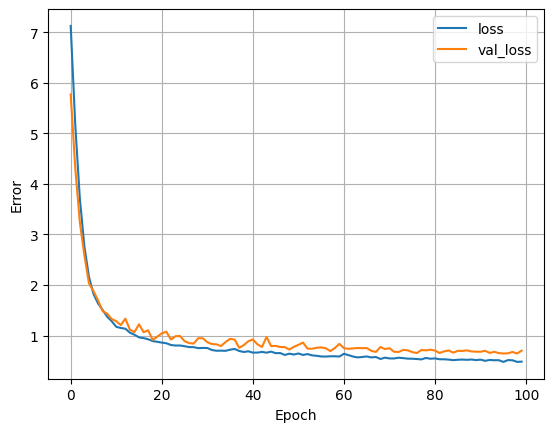

In [11]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(dnn_history)

Evaluate performance out-of-sample on the testing data set

In [38]:
best_model.evaluate(X_test, y_test)

79/79 [==============================] - 0s 930us/step - loss: 1.1290 - accuracy: 1.0000


[1.1289503574371338, 1.0]

Print the true and predicted poses

In [37]:
print("Actual:")
print(y_test)

print("Predicted:")
predictions = best_model.predict(X_test)
print(pd.DataFrame(predictions, columns=y_variables))

Actual:
          pos_x      pos_y      pos_z     rot_x     rot_y     rot_z
3741  20.333391   3.652711  -1.208845 -0.158652 -0.042135  0.263581
9219  45.294640  15.791813   8.372956  0.171466 -0.366214 -0.734563
355    9.493512  -5.401581   2.087808  0.142615 -0.042771  0.562513
7448  31.546106  15.311429   0.649132 -0.138181  0.578481  0.622221
3407  51.868752  -9.980073  -3.370181 -0.095203  0.483281  2.472045
...         ...        ...        ...       ...       ...       ...
7371   7.070657   4.513583  -2.096345  0.002727 -0.047692 -2.328843
3808  34.753090  10.212715 -10.489415  0.046053  0.087386 -2.879217
20    58.894653  30.144754 -18.557043  0.015419 -0.405312 -2.650370
5851  60.550377 -21.700560 -14.656321  0.000121 -0.712185 -0.173900
6012  26.096327 -15.570047  -0.801971 -0.034567 -0.118828  0.663250

[2500 rows x 6 columns]
Predicted:
79/79 [==============================] - 0s 844us/step
          pos_x      pos_y      pos_z     rot_x     rot_y     rot_z
0     21.497316  

---

## Tuning